# State-space Gaussian processes




Gaussian processes (GPs) scale as $O(N^3)$, where $N$ is the number of data points, which is problematic for large datasets.
By parametrising the GP as a stochastic differential equation, we can reformulate the GP regression problem using a state-space representation, where it can be solved using Kalman filtering with linear time complexity ($O(N)$).

In this minimal example, we will use the state-space representation of the Matérn-5/2 covariance function (in the paper, the case $p=2$, so $\nu = p + 1/2= 5/2$), a typical choice for spatial and temporal problems.

Need to train lengthscale ($\ell$) and variance ($\alpha$) of kernel during fitting, as well as the likelihood noise $\sigma$

$$
\begin{align*}
\underbrace{\begin{pmatrix} z^1_t \\ z^2_t \\ z^3_t \end{pmatrix}}_{z_t}
  =
\underbrace{
\begin{pmatrix}
0 & 1 & 0 \\
0 & 0 & 1 \\
-\lambda^3 & -3 \lambda^2 & -3 \lambda
\end{pmatrix}
}_{F}
\underbrace{\begin{pmatrix} z^1_{t-1} \\ z^2_{t-1} \\ z^3_{t-1} \end{pmatrix}}_{z_{t-1}} + q_t
\end{align*}
$$

Some helpers:
$$
\begin{align*}
\lambda = \sqrt{5} / \ell \\
q_t = 
\begin{pmatrix}
0 \\
0 \\
1
\end{pmatrix} w(t)
\end{align*}
$$
where $w(t)$ is some white noise process

The observation model is

$$
\begin{align*}
y_t
  &=
    \underbrace{
    \begin{pmatrix}
1 & 0 & 0
    \end{pmatrix}
    }_{H}
    \;
\underbrace{\begin{pmatrix} z^1_t \\ z^2_t \\ z^3_t \end{pmatrix}}_{z_t}   
 + r_t
\end{align*}
$$

where $r_t \sim \mathcal{N}(0, \sigma^2)$

Refs:
- Temporal Gaussian Process Regression in Logarithmic Time https://arxiv.org/pdf/2102.09964.pdf
- KALMAN FILTERING AND SMOOTHING SOLUTIONS TO TEMPORAL GAUSSIAN PROCESS REGRESSION MODELS https://users.aalto.fi/~ssarkka/pub/gp-ts-kfrts.pdf
- https://github.com/EEA-sensors/parallel-gps/blob/main/pssgp/kernels/matern/common.py
- https://github.com/AaltoML/BayesNewton/blob/main/bayesnewton/kernels.py#L238
- https://github.com/SheffieldML/GPy/blob/devel/GPy/kern/src/sde_matern.py



## Setup

In [1]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [2]:
from jax import numpy as jnp
from jax import random as jr
from jax import vmap
from matplotlib import pyplot as plt

from dynamax.utils.plotting import plot_uncertainty_ellipses
from dynamax.linear_gaussian_ssm import LinearGaussianSSM, ParamsLGSSM
from dynamax.linear_gaussian_ssm import lgssm_smoother, lgssm_filter


## Create the model

In [3]:
# Create object
lgssm = LinearGaussianSSM(state_dim = 3, emission_dim = 1)

# hyperparameters, to learn
# ell, lengthscale of kernel
# alpha, variance of kernel
# sigma, observation noise

# what are the initial mean and covariance?
# initial_mean =
# initial_covariance =

# F, dynamics model
lambda_ = np.sqrt(5) / ell
F  = jnp.array([[0, 1, 0],
                [0, 0, 1],
                [-lambda_**3, -3*lambda_**2, -3*lambda_]])

# q, dynamics covariance
Q #= needs to be state_dim x state_dim, seems to be L w(t)

# How to write this as covariance Q?
# L = jnp.array([[0], [0], [1]])
# w = np.array([[alpha * 400.0 * 5.0 ** 0.5 / 3.0 / ell ** 5.0]])
# L @ w

# H, emission model weights
H = jnp.array([[1., 0., 0.]])

# R, emission_covariance
R = jnp.ones((1, 1)) * sigma

# Initialize model
params, _ = lgssm.initialize(jr.PRNGKey(0),
                             initial_mean=initial_mean,
                             initial_covariance=initial_covariance,
                             dynamics_weights=F,
                             dynamics_covariance=Q,
                             emission_weights=H,
                             emission_covariance=R)


## Create some test data

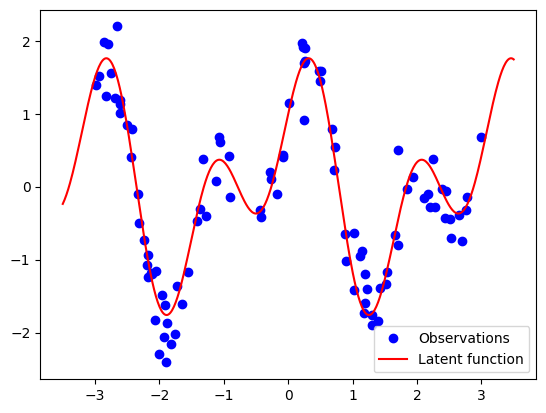

In [30]:
key = jr.PRNGKey(123)

n = 100
noise = 0.3

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

fig, ax = plt.subplots()
ax.plot(x, y, "o", label="Observations", color="blue")
ax.plot(xtest, ytest, label="Latent function", color="red")
ax.legend(loc="best")



## Perform online filtering



In [31]:
# lgssm_posterior = lgssm.filter(params, ytest)
# print(lgssm_posterior.filtered_means.shape)
# print(lgssm_posterior.filtered_covariances.shape)
# print(lgssm_posterior.marginal_loglik)

# in the current interface, we can only infer entire covariance/emission matrices
# we want to infer alpha, ell, sigma from the data
# What is the correct interface of dynamax for this?

# This is an example of training NN weights
# https://probml.github.io/dynamax/notebooks/generalized_gaussian_ssm/cmgf_mlp_classification_demo.html

# cmgf_ekf_params = ParamsLGSSM(
#     initial_mean=flat_params,
#     initial_covariance=jnp.eye(state_dim),
#     dynamics_function=lambda w, x: w,
#     dynamics_covariance=jnp.eye(state_dim) * 1e-4,
#     emission_mean_function = lambda w, x: sigmoid_fn(w, x),
#     emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))
# )
# the filter this object